# DPU example: MNIST Classifier

This notebook shows how to deploy Convolutional Neural Network (CNN) model for 
hand-written digit recognition. The network was trained on the MNIST dataset,
quantized using Vitis AI compiler tools, and deployed on the DPU.

Compared to the other 3 notebooks delivered in this folder, this notebook
shows how to deploy a **user-trained** DPU model on PYNQ image; i.e., 
the model used in this notebook does not come from the model zoo.
Refer to [train your own DPU models](https://github.com/Xilinx/DPU-PYNQ/tree/master/host#train-your-own-dpu-models-from-scratch)
to get more information.

## 1. Prepare the overlay

We will download the overlay onto the board. Then we will load the 
corresponding DPU model.

In [1]:
from pynq_dpu import DpuOverlay
overlay = DpuOverlay("dpu.bit")
overlay.load_model("dpu_mnist_classifier_0.elf")

Let's import some libraries as well.

In [2]:
from time import time
import numpy as np
import mnist
from dnndk import n2cube
import matplotlib.pyplot as plt

## 2. Load test data

The `mnist` package enables the following data for users:

* `test_images()`: returns test images stored as a numpy array. 
Each image is a grayscale 28x28 pixels, representing a digit between 0 and 9.
* `test_labels()`: returns a list of the true labels stored as numpy array.


There are 2 pre-processing steps we need to do to the test images 
before we can use it:

1. The raw numpy array delivered by `mnist` has a data type of 
uint8 (data ranges from 0 to 255); we need to normalize the elements to 
floating-point numbers ranging from 0 to 1.
2. The DNNDK API will expect each input sample to have 3 dimensions; 
so we need to expand the original numpy array.

In [3]:
raw_data = mnist.test_images()
normalized_data = np.asarray(raw_data/255, dtype=np.float32)
test_data = np.expand_dims(normalized_data, axis=3)
test_label = mnist.test_labels()

print("Total number of test images: {}".format(test_data.shape[0]))
print("  Dimension of each picture: {}x{}".format(test_data.shape[1],
                                                  test_data.shape[2]))

Total number of test images: 10000
  Dimension of each picture: 28x28


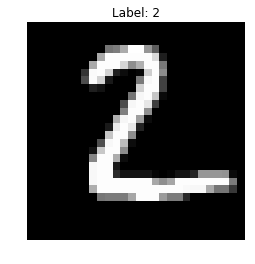

In [4]:
plt.imshow(test_data[1,:,:,0], 'gray')
plt.title('Label: {}'.format(test_label[1]))
plt.axis('off')
plt.show()

## 3. Set up DPU

We can set the DPU kernel name, and input/output nodes.
These pieces of information can be found from the Vitis AI compiler output.

In [5]:
KERNEL_NAME = "mnist_classifier_0"
KERNEL_CONV_INPUT = "conv2d_1_convolution"
KERNEL_FC_OUTPUT = "output_logits_MatMul"

Use `n2cube` to attach to the kernel driver. Load the kernel and create a task for it.

In [6]:
n2cube.dpuOpen()
kernel = n2cube.dpuLoadKernel(KERNEL_NAME)
task = n2cube.dpuCreateTask(kernel, 0)

Get input and output dimensions for the task, we will use these for later computations.

In [7]:
input_len = n2cube.dpuGetInputTensorSize(task, KERNEL_CONV_INPUT)
size = n2cube.dpuGetOutputTensorSize(task, KERNEL_FC_OUTPUT)
channel = n2cube.dpuGetOutputTensorChannel(task, KERNEL_FC_OUTPUT)
conf = n2cube.dpuGetOutputTensorAddress(task, KERNEL_FC_OUTPUT)
outputScale = n2cube.dpuGetOutputTensorScale(task, KERNEL_FC_OUTPUT)

## 4. Run DPU to make predictions

We can now classify a couple of digit pictures. For each picture, 
the classification result (shown as 'Prediction') is displayed on top of 
the picture. 

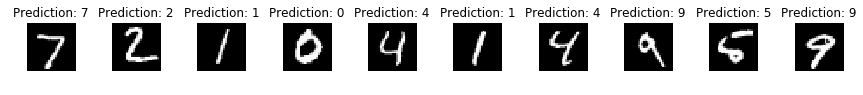

In [8]:
num_pics  = 10
fix, ax = plt.subplots(1, num_pics, figsize=(12,12))
plt.tight_layout()
for i in range(num_pics):
    n2cube.dpuSetInputTensorInHWCFP32(task, KERNEL_CONV_INPUT, 
                                      test_data[i], input_len)
    n2cube.dpuRunTask(task)
    softmax = n2cube.dpuRunSoftmax(conf, channel, size//channel, outputScale)
    prediction = softmax.argmax()

    ax[i].set_title('Prediction: {}'.format(prediction))
    ax[i].axis('off')
    ax[i].imshow(test_data[i,:,:,0], 'gray')

We can also evaluate on the entire test dataset.

In [9]:
total = test_data.shape[0]
predictions = np.empty_like(test_label)
print("Classifying {} digit pictures ...".format(total))

start = time()
for i in range(total):
    n2cube.dpuSetInputTensorInHWCFP32(task, KERNEL_CONV_INPUT,
                                      test_data[i], input_len)
    n2cube.dpuRunTask(task)
    softmax = n2cube.dpuRunSoftmax(conf, channel, size//channel, outputScale)
    predictions[i] = softmax.argmax()
stop = time()
correct = np.sum(predictions==test_label)
execution_time = stop-start
print("Overall accuracy: {}".format(correct/total))
print("  Execution time: {:.4f}s".format(execution_time))
print("      Throughput: {:.4f}FPS".format(total/execution_time))

Classifying 10000 digit pictures ...
Overall accuracy: 0.9858
  Execution time: 8.7825s
      Throughput: 1138.6244FPS


Make sure to clean up when you are done.

In [10]:
n2cube.dpuDestroyKernel(kernel)
n2cube.dpuDestroyTask(task)

0

Copyright (C) 2020 Xilinx, Inc